In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.ao.quantization import QuantStub, DeQuantStub
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device={device}")

Device=cuda


In [2]:
from models.cifar_resnet32 import ResNet32

model = ResNet32().to('cuda' if torch.cuda.is_available() else 'cpu')
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy

def load_dataset(path='./data', batch_size=64, num_workers=4):
    print("Loading the CIFAR10 dataset")

    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
    ])

    train_dataset = datasets.CIFAR10(root=path, train=True, download=True, transform=transform)
    test_dataset  = datasets.CIFAR10(root=path, train=False, download=True, transform=test_transform)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,   # <-- use workers
        pin_memory=True,           # <-- good for GPU
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size * 2, # eval can use bigger batch
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    print(
        f"Loaded train data: {len(train_loader.dataset)} samples, {len(train_loader)} batches\n"
        f"Loaded test data:  {len(test_loader.dataset)} samples, {len(test_loader)} batches"
    )

    return train_loader, test_loader

In [4]:
train_loader, test_loader = load_dataset(batch_size=128, num_workers=2)

Loading the CIFAR10 dataset
Loaded train data: 50000 samples, 391 batches
Loaded test data:  10000 samples, 40 batches


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(metrics):
  train_losses = metrics.get('train_loss',None)
  test_losses = metrics.get('test_loss',None)
  train_accs = metrics.get('train_acc',None)
  test_accs = metrics.get('test_acc',None)

  epochs = range(1, len(train_losses) + 1)

  plt.figure(figsize=(12, 5))

  # Loss Graph
  plt.subplot(1, 2, 1)
  if train_losses:
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
  if test_losses:
    plt.plot(epochs, test_losses, label='Test Loss', marker='s')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training vs Test Loss')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)

  # Accuracy Graph
  plt.subplot(1, 2, 2)
  if train_accs:
    plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')
  if test_accs:
    plt.plot(epochs, test_accs, label='Test Accuracy', marker='s')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.title('Training vs Test Accuracy')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)

  plt.tight_layout()
  plt.show()

def plot_weight_histogram(model, bins=50):
  all_weights = []

  for name, module in model.named_modules():
      if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
          weights = module.weight.detach().cpu().numpy().flatten()
          all_weights.extend(weights)

  all_weights = np.array(all_weights)

  plt.figure(figsize=(8,6))
  plt.hist(all_weights, bins=bins, color='skyblue', edgecolor='black')
  plt.title("Weight Distribution Histogram")
  plt.xlabel("Weight Value")
  plt.ylabel("Frequency")
  plt.grid(True, alpha=0.3)
  plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model,
                train_loader,
                test_loader,
                device='cpu',
                epochs=10,
                lr=1e-3,
                train=True,
                test=True):
    """
    Generic training helper:
      - uses SGD (to match your ResNet32 training)
      - logs train/test loss & accuracy per epoch
      - returns a metrics dict you can use for plotting
    """
    model.to(device)

    metrics = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9,
        weight_decay=5e-4
    )

    for e in range(epochs):
        print(f"Epoch [{e+1}/{epochs}] ", end='')

        # ---- TRAIN ----
        if train:
            model.train()
            train_loss, total_examples, correct = 0.0, 0, 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * labels.size(0)
                _, pred_ind = outputs.max(1)
                total_examples += labels.size(0)
                correct += pred_ind.eq(labels).sum().item()

            train_loss /= total_examples
            train_acc = 100.0 * correct / total_examples

            metrics["train_loss"].append(train_loss)
            metrics["train_acc"].append(train_acc)

            print(f"Train Loss: {train_loss:.4f}, "
                  f"Train Acc: {train_acc:.2f}% ", end='')

        # ---- TEST / VALIDATION ----
        if test:
            model.eval()
            test_loss, total_examples, correct = 0.0, 0, 0

            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item() * labels.size(0)
                    _, pred_ind = outputs.max(1)
                    total_examples += labels.size(0)
                    correct += pred_ind.eq(labels).sum().item()

            test_loss /= total_examples
            test_acc = 100.0 * correct / total_examples

            metrics["test_loss"].append(test_loss)
            metrics["test_acc"].append(test_acc)

            print(f"Test/Val Loss: {test_loss:.4f}, "
                  f"Test/Val Acc: {test_acc:.2f}%")

    return metrics

In [7]:
from models.cifar_resnet32 import ResNet32
import torch

model = ResNet32(num_classes=10)
model.load_state_dict(torch.load("checkpoints/resnet32_fp32_best.pt", map_location="cpu"))

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

model_size_MB = total_params * 4 / (1024 ** 2)
print(f"Model Size (FP32): {model_size_MB:.2f} MB")

Total Parameters: 466,906
Trainable Parameters: 466,906
Model Size (FP32): 1.78 MB


In [8]:
print(f"Running on: {device}")

Running on: cuda


In [9]:
train, test = True, True
epochs = 100
fp32_metrics = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    train=train,
    test=test,
    device=device,
    epochs=epochs
)

Epoch [1/100] Train Loss: 0.4560, Train Acc: 84.57% Test/Val Loss: 0.2615, Test/Val Acc: 91.29%
Epoch [2/100] Train Loss: 0.4098, Train Acc: 86.10% Test/Val Loss: 0.2620, Test/Val Acc: 91.31%
Epoch [3/100] Train Loss: 0.4008, Train Acc: 86.33% Test/Val Loss: 0.2609, Test/Val Acc: 91.54%
Epoch [4/100] Train Loss: 0.3845, Train Acc: 86.83% Test/Val Loss: 0.2553, Test/Val Acc: 91.48%
Epoch [5/100] Train Loss: 0.3771, Train Acc: 87.20% Test/Val Loss: 0.2535, Test/Val Acc: 91.71%
Epoch [6/100] Train Loss: 0.3727, Train Acc: 87.35% Test/Val Loss: 0.2529, Test/Val Acc: 91.72%
Epoch [7/100] Train Loss: 0.3670, Train Acc: 87.41% Test/Val Loss: 0.2506, Test/Val Acc: 91.81%
Epoch [8/100] Train Loss: 0.3654, Train Acc: 87.41% Test/Val Loss: 0.2497, Test/Val Acc: 91.87%
Epoch [9/100] Train Loss: 0.3613, Train Acc: 87.75% Test/Val Loss: 0.2471, Test/Val Acc: 91.93%
Epoch [10/100] Train Loss: 0.3534, Train Acc: 87.91% Test/Val Loss: 0.2483, Test/Val Acc: 91.79%
Epoch [11/100] Train Loss: 0.3528, Trai

In [14]:
torch.save(model.state_dict(), "checkpoints/resnet32_fp32_trained.pt")
torch.save(fp32_metrics, "checkpoints/resnet32_fp32_metrics.pt")

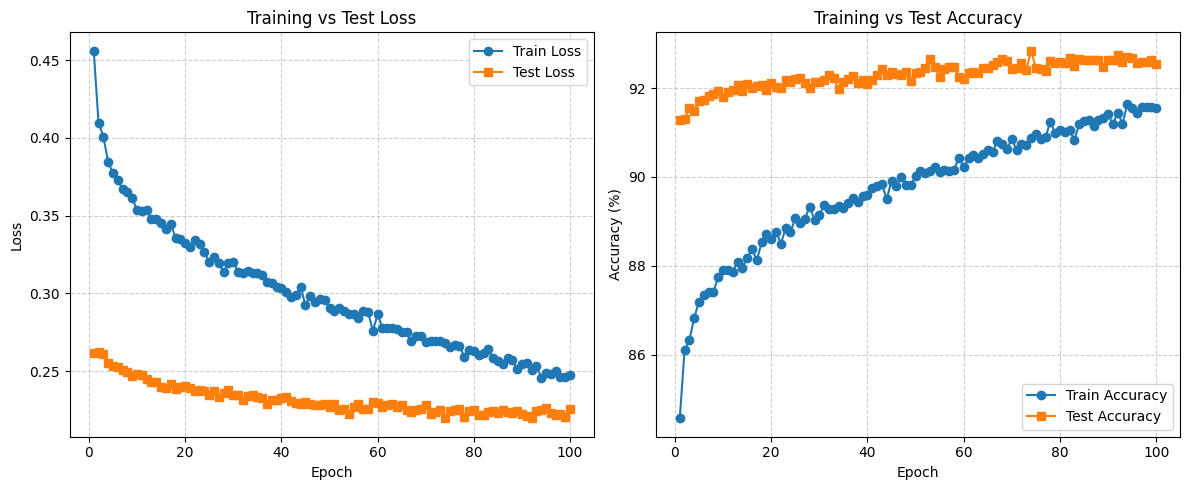

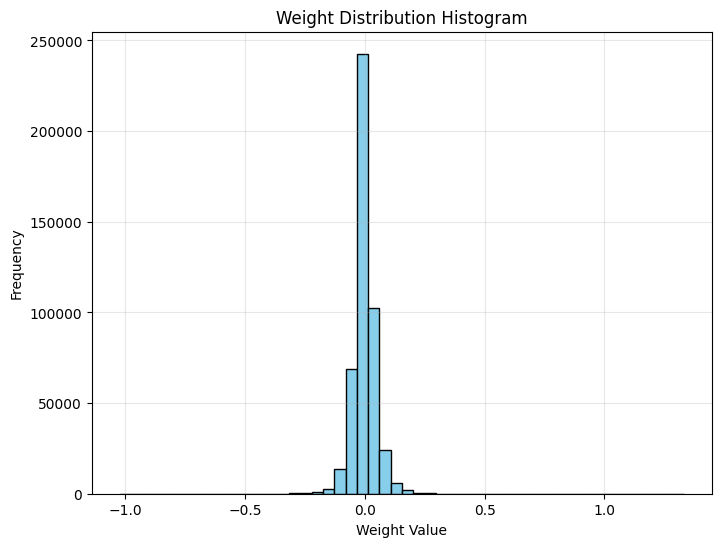

In [15]:
metrics = torch.load("checkpoints/resnet32_fp32_metrics.pt")
plot_metrics(metrics)
plot_weight_histogram(model)

In [16]:
model = ResNet32(num_classes=10)
model.load_state_dict(torch.load("checkpoints/resnet32_fp32_best.pt"))
model.train()

#model = SqueezeNetCIFAR10()
#model.load_model("squeezenet_dataaug_cifar10_fp32.pth", device=device)
#model.train()

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [24]:
import copy
import torch.nn.utils.prune as prune
import torch

prune_levels = [0.1, 0.3, 0.5, 0.7]
results = []

# Per–sparsity hyperparams (tweak these if you like)
prune_cfg = {
    0.1: {"lr": 1e-2, "epochs": 10},   # light pruning
    0.3: {"lr": 2e-2, "epochs": 15},   # medium
    0.5: {"lr": 3e-2, "epochs": 20},   # heavy
    0.7: {"lr": 5e-2, "epochs": 25},   # very heavy
}

for p in prune_levels:
    cfg = prune_cfg[p]
    lr = cfg["lr"]
    epochs = cfg["epochs"]

    print(f"\n=== Pruning {p*100:.0f}% of weights (global L1) ===")
    print(f"Using lr={lr}, epochs={epochs}")

    # 1) Start from the trained FP32 baseline
    m = copy.deepcopy(model)  # 'model' = trained FP32 ResNet32

    # 2) Collect all Conv/Linear weights to prune
    parameters_to_prune = []
    for module in m.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            parameters_to_prune.append((module, "weight"))

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=p,
    )

    # 3) Fine-tune the pruned model
    metrics = train_model(
        model=m,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        epochs=epochs,
        lr=lr,
        train=True,
        test=True,
    )

    # 4) Remove pruning reparam so weights are plain tensors
    for module in m.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            if hasattr(module, "weight_orig"):
                prune.remove(module, "weight")

    # 5) Save the pruned fine-tuned model + metrics
    percent = int(p * 100)
    model_path   = f"checkpoints/resnet32_pruned_{percent}pct.pt"
    metrics_path = f"checkpoints/resnet32_pruned_{percent}pct_metrics.pt"

    torch.save(m.state_dict(), model_path)
    torch.save(metrics, metrics_path)

    print(f"Saved pruned model to {model_path}")
    print(f"Saved metrics to    {metrics_path}")

    results.append((p, metrics))


=== Pruning 10% of weights (global L1) ===
Using lr=0.01, epochs=10
Epoch [1/10] Train Loss: 0.5926, Train Acc: 79.68% Test/Val Loss: 0.3649, Test/Val Acc: 87.36%
Epoch [2/10] Train Loss: 0.5294, Train Acc: 81.98% Test/Val Loss: 0.3535, Test/Val Acc: 88.07%
Epoch [3/10] Train Loss: 0.5105, Train Acc: 82.50% Test/Val Loss: 0.3376, Test/Val Acc: 88.50%
Epoch [4/10] Train Loss: 0.4916, Train Acc: 82.97% Test/Val Loss: 0.3485, Test/Val Acc: 88.03%
Epoch [5/10] Train Loss: 0.4772, Train Acc: 83.55% Test/Val Loss: 0.3248, Test/Val Acc: 88.72%
Epoch [6/10] Train Loss: 0.4693, Train Acc: 83.81% Test/Val Loss: 0.3326, Test/Val Acc: 88.42%
Epoch [7/10] Train Loss: 0.4609, Train Acc: 84.07% Test/Val Loss: 0.3277, Test/Val Acc: 88.98%
Epoch [8/10] Train Loss: 0.4544, Train Acc: 84.42% Test/Val Loss: 0.3214, Test/Val Acc: 89.11%
Epoch [9/10] Train Loss: 0.4475, Train Acc: 84.61% Test/Val Loss: 0.3197, Test/Val Acc: 89.09%
Epoch [10/10] Train Loss: 0.4393, Train Acc: 84.87% Test/Val Loss: 0.3456, T

Metrics for pruning with p=0.1


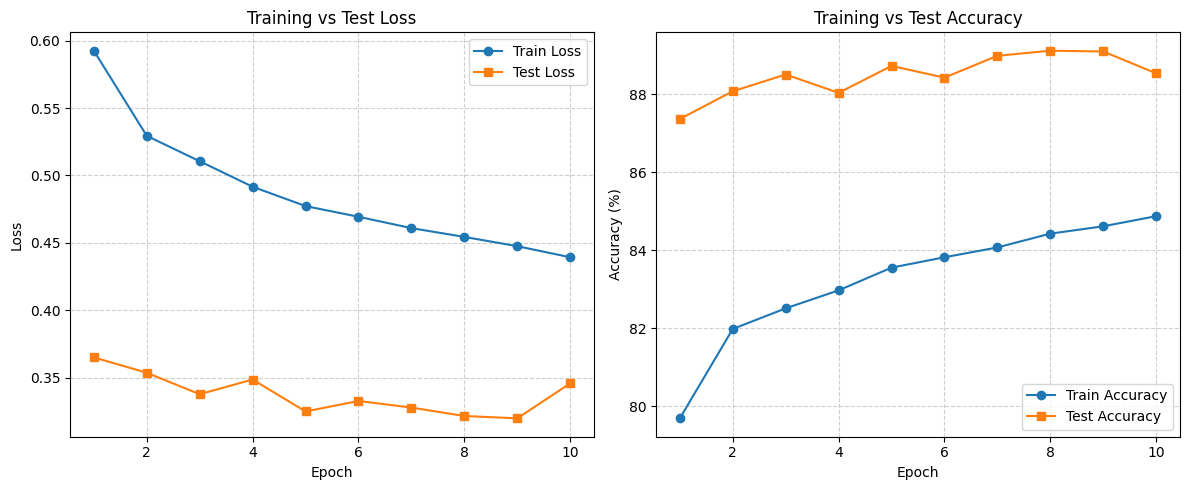

Metrics for pruning with p=0.3


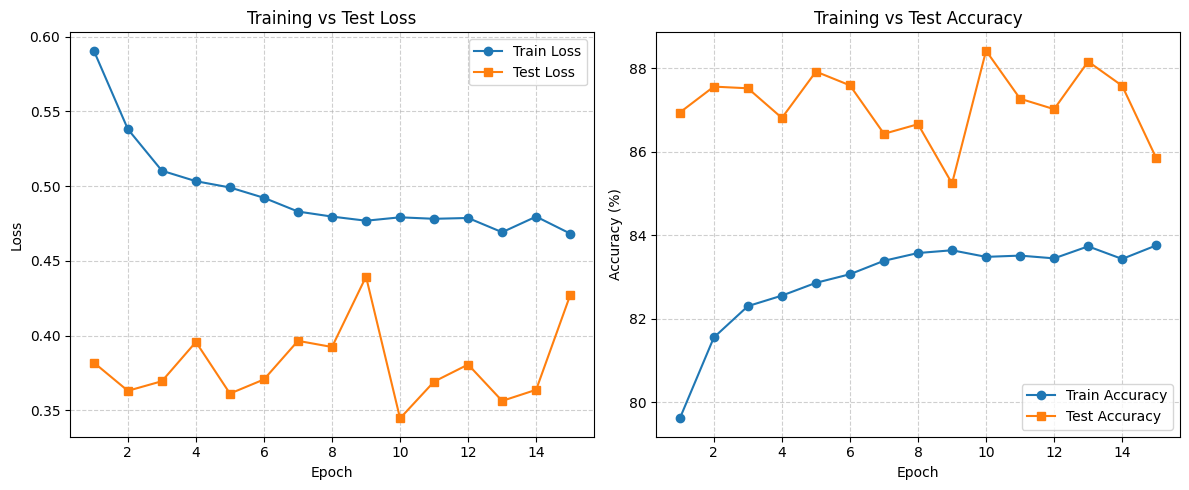

Metrics for pruning with p=0.5


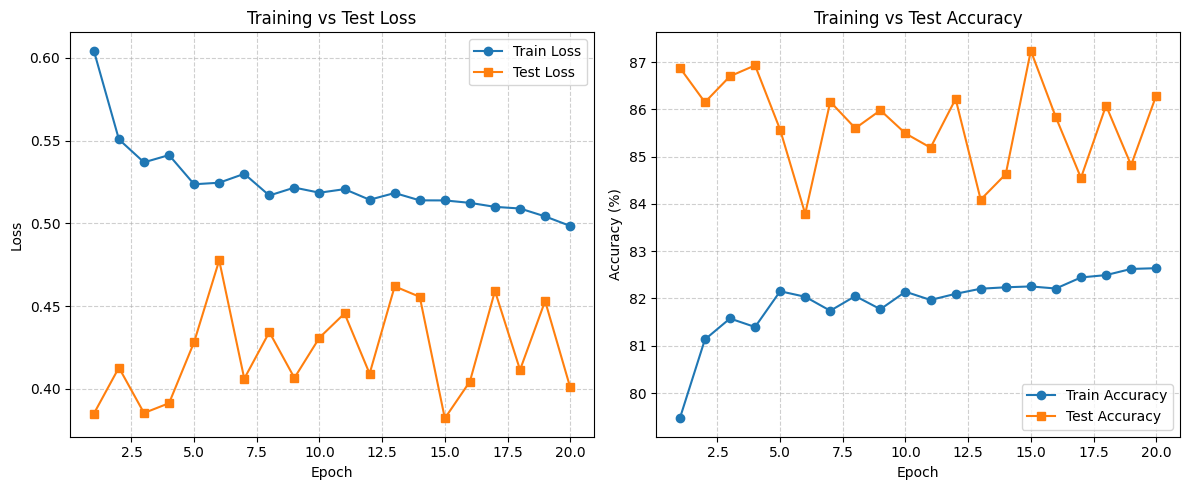

Metrics for pruning with p=0.7


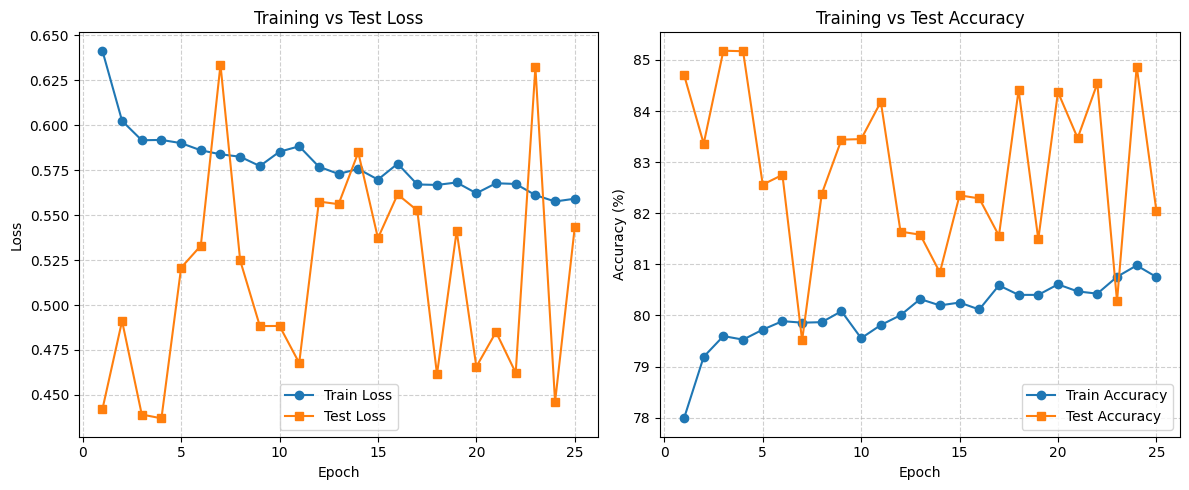

In [25]:
for p, metrics in results:
    print(f"Metrics for pruning with p={p}")
    plot_metrics(metrics)

In [27]:
import torch
import torch.nn as nn
from torch.ao.quantization import get_default_qat_qconfig
from torch.ao.quantization.quantize_fx import prepare_qat_fx, convert_fx

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Start from your pruned FP32 model
model_qat = ResNet32(num_classes=10)
state_dict = torch.load("checkpoints/resnet32_pruned_50pct.pt",
                        map_location="cpu")
model_qat.load_state_dict(state_dict)

# For QAT you want the model in TRAIN mode when preparing
model_qat.train()

# 2) Example input for FX (shape must match CIFAR-10)
example_inputs = (torch.randn(1, 3, 32, 32),)

# 3) QAT config: fake-quant based on fbgemm backend
qconfig_dict = {"": get_default_qat_qconfig("fbgemm")}

# 4) Prepare the model for QAT (inserts fake quant + observers)
model_qat_prepared = prepare_qat_fx(model_qat, qconfig_dict,
                                    example_inputs=example_inputs)

# Move to GPU for training if available
model_qat_prepared.to(device)
model_qat_prepared.train()
print("QAT model ready on:", device)

/tmp/SLURM_5175214/ipykernel_1444348/637032675.py:24: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_qat_prepared = prepare_qat_fx(model_qat, qconfig_dict,
/home1/ihsiao/.conda/envs/ee599/lib/python3.12/site-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future ve

QAT model ready on: cuda


In [28]:
qat_metrics = train_model(
    model=model_qat_prepared,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    epochs=20,    # 20–30 epochs is typical for QAT fine-tune
    lr=1e-3,      # usually lower LR than baseline
    train=True,
    test=True,
)

Epoch [1/20] Train Loss: 0.4306, Train Acc: 85.25% Test/Val Loss: 0.2900, Test/Val Acc: 90.06%
Epoch [2/20] Train Loss: 0.3917, Train Acc: 86.40% Test/Val Loss: 0.2809, Test/Val Acc: 90.53%
Epoch [3/20] Train Loss: 0.3778, Train Acc: 87.02% Test/Val Loss: 0.2764, Test/Val Acc: 90.53%
Epoch [4/20] Train Loss: 0.3721, Train Acc: 87.19% Test/Val Loss: 0.2725, Test/Val Acc: 90.81%
Epoch [5/20] Train Loss: 0.3662, Train Acc: 87.38% Test/Val Loss: 0.2718, Test/Val Acc: 90.76%
Epoch [6/20] Train Loss: 0.3601, Train Acc: 87.48% Test/Val Loss: 0.2692, Test/Val Acc: 90.95%
Epoch [7/20] Train Loss: 0.3589, Train Acc: 87.67% Test/Val Loss: 0.2680, Test/Val Acc: 90.89%
Epoch [8/20] Train Loss: 0.3545, Train Acc: 87.77% Test/Val Loss: 0.2658, Test/Val Acc: 91.15%
Epoch [9/20] Train Loss: 0.3459, Train Acc: 88.22% Test/Val Loss: 0.2648, Test/Val Acc: 90.98%
Epoch [10/20] Train Loss: 0.3454, Train Acc: 88.12% Test/Val Loss: 0.2636, Test/Val Acc: 91.27%
Epoch [11/20] Train Loss: 0.3409, Train Acc: 88.2

In [30]:
from torch.ao.quantization.quantize_fx import convert_fx

# 5) Convert to real INT8 model (must be on CPU & eval)
model_qat_prepared.to("cpu")
model_qat_prepared.eval()

# (optional but common: disable observers & freeze BN if you haven’t already)
# from torch.ao.quantization import disable_observer
# from torch.ao.nn.intrinsic.qat import freeze_bn_stats
# model_qat_prepared.apply(torch.ao.quantization.disable_observer)
# model_qat_prepared.apply(torch.ao.quantization.freeze_bn_stats)

model_int8 = convert_fx(model_qat_prepared)   # <-- no example_inputs here

# Save INT8 model
torch.save(model_int8.state_dict(),
           "checkpoints/resnet32_pruned50_int8_qat_fx.pt")
print("Saved INT8 QAT model.")

Saved INT8 QAT model.


/tmp/SLURM_5175214/ipykernel_1444348/3824306496.py:13: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8 = convert_fx(model_qat_prepared)   # <-- no example_inputs here


In [31]:
def evaluate(model, test_loader):
    model.eval()
    model.to('cpu')
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cpu'), labels.to('cpu')
            outputs = model(images)
            _, pred = outputs.max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)

    acc = 100.0 * correct / total
    return acc

acc = evaluate(model_int8,test_loader)
print(f"INT8 with QAT Test Accuracy: {acc}%")

INT8 with QAT Test Accuracy: 91.18%


In [40]:
import torch
from torch.ao.quantization import get_default_qconfig
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx

# 0. Use the same backend everywhere
torch.backends.quantized.engine = "fbgemm"

# 1. Load your pruned FP32 model **on CPU**
from models.cifar_resnet32 import ResNet32

model_fp32 = ResNet32(num_classes=10)
state = torch.load("checkpoints/resnet32_pruned_50pct.pt",
                   map_location="cpu")
model_fp32.load_state_dict(state)
model_fp32.eval()          # important
model_fp32.to("cpu")       # make sure it's really CPU

# 2. Prepare FX PTQ
example_inputs = (torch.randn(1, 3, 32, 32),)  # CPU tensor

qconfig_dict = {"": get_default_qconfig("fbgemm")}  # static PTQ config

model_ptq_prepared = prepare_fx(model_fp32, qconfig_dict, example_inputs)

# 3. Calibrate on a few training batches (CPU only)
from torch.utils.data import DataLoader

with torch.inference_mode():
    for i, (images, _) in enumerate(train_loader):
        images = images.to("cpu")
        model_ptq_prepared(images)
        if i == 20:      # ~20 batches is plenty
            break

# 4. Convert to real INT8
model_int8_ptq = convert_fx(model_ptq_prepared)
model_int8_ptq.eval()
model_int8_ptq.to("cpu")    # quantized ops are CPU-only

/tmp/SLURM_5175214/ipykernel_1444348/1696748190.py:23: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_ptq_prepared = prepare_fx(model_fp32, qconfig_dict, example_inputs)
/home1/ihsiao/.conda/envs/ee599/lib/python3.12/site-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported 

GraphModule(
  (conv1): QuantizedConvReLU2d(3, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.03465345501899719, zero_point=0, padding=(1, 1))
  (layer1): Module(
    (0): Module(
      (conv1): QuantizedConvReLU2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.022430874407291412, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.05751296877861023, zero_point=64, padding=(1, 1))
    )
    (1): Module(
      (conv1): QuantizedConvReLU2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.022960208356380463, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.05169299989938736, zero_point=66, padding=(1, 1))
    )
    (2): Module(
      (conv1): QuantizedConvReLU2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.017879068851470947, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.04035576432943344, z

In [41]:
import torch

torch.backends.quantized.engine = "fbgemm"  # same backend you used for PTQ

@torch.no_grad()
def evaluate_int8_cpu(model, loader):
    model.eval()
    model.to("cpu")

    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to("cpu")
        labels = labels.to("cpu")

        outputs = model(images)
        _, preds = outputs.max(1)

        total   += labels.size(0)
        correct += (preds == labels).sum().item()

    return 100.0 * correct / total

# ---- actually evaluate your INT8 PTQ-FX model ----
acc = evaluate_int8_cpu(model_int8_ptq, test_loader)
print(f"INT8 PTQ-FX Test Accuracy: {acc:.2f}%")

INT8 PTQ-FX Test Accuracy: 86.12%
